In [1]:
%load_ext autotime

In [2]:
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import numpy as np
from collections import Counter

from covid19_abm.dir_manager import get_data_dir

time: 2.58 s


In [3]:
age_map = {
    'less than 1 year': 0,
    'less than 1 year ': 0,
    '1 year': 1,
    '1 year ': 1,
    '2 years': 2,
    '2 years ': 2,
    '98': 98,
    '98 ': 98,
    'not reported/missing': None,
    'not reported/missing ': None,
}

econ_stat_map = {
    'Not working, inactive, not': 'Not working, inactive, not in universe',
    'Current Students': 'In School',
}

full_individual_df = pd.read_stata(
    get_data_dir('raw', 'census', 'abm_individual_new_092220_final_merged_complete_FINAL.dta'))

full_individual_df['age'] = full_individual_df['age'].map(lambda x: age_map.get(x, x))


full_individual_df['economic_status'] = full_individual_df['economic_status'].astype(str)
full_individual_df.loc[full_individual_df['teachers'] != 0, 'economic_status'] = 'Teachers'
full_individual_df['economic_status'] = full_individual_df['economic_status'].str.strip().map(lambda x: econ_stat_map.get(x, x))

time: 2min 26s


In [4]:
full_individual_df['economic_status'].value_counts()

In School                                 4603312
Not working, inactive, not in universe    3655252
Agriculture Workers                       2407410
Service Workers                           2235255
Homemakers/Housework                      1323535
Office workers                             342493
Disabled and not working                   177445
Teachers                                   143152
Indusrtry Workers                          126592
In the army                                 43378
Name: economic_status, dtype: int64

time: 1.1 s


In [5]:
full_individual_df.head(1)

,serial,persons,strata,gq,urban,hhtype,nfams,pernum,famunit,famsize,...,mean_econ_stat_9,Name,SchoolLevel,Grant_Class,Ed_dist,Type,HotseatingIndicator,hotseating_session,phase,boardingschool
0,155315000,4,2614,households,urban,married/cohab couple with children,1 family,3,1,4,...,0.0063,ADMIRAL TAIT,Primary,P1,Harare,Government,1.0,Morning,5.0,Not Boarding School


time: 28.2 ms


In [6]:
l = '''Not working, inactive, not in universe
In School
Homemakers/Housework
Office workers
Teachers
Service Workers
Agriculture Workers
Indusrtry Workers
In the army
Disabled and not working'''
l = l.split('\n')
full_individual_df['economic_status'].value_counts()[l]

Not working, inactive, not in universe    3655252
In School                                 4603312
Homemakers/Housework                      1323535
Office workers                             342493
Teachers                                   143152
Service Workers                           2235255
Agriculture Workers                       2407410
Indusrtry Workers                          126592
In the army                                 43378
Disabled and not working                   177445
Name: economic_status, dtype: int64

time: 1.11 s


In [7]:
full_individual_df["school_goers"].value_counts()

0.0    10319939
1.0     4737885
Name: school_goers, dtype: int64

time: 138 ms


In [8]:
(
    ((full_individual_df["teachers"] > 0) & (full_individual_df["school_goers"] > 0)).sum(),
    ((full_individual_df["teachers"] > 0) & (full_individual_df["school_goers"] > 0) & (full_individual_df["Schoolnumber"].notnull())).sum(),
    (full_individual_df["teachers"] > 0).sum()
)

(134573, 134573, 143152)

time: 108 ms


# Fill unknown age

In [9]:
individual_df = full_individual_df

age_cols = [
    'new_district_id',
    'urban', 'persons', 'sex', 'marst', 'citizen', 'race', 'disabled', 'economic_status']
X = pd.get_dummies(individual_df[age_cols], drop_first=True)

X_train = X[individual_df['age'].notnull()]

time: 4.32 s


In [10]:
gb = GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=1029)
# rf = RandomForestRegressor(n_estimators=100, max_depth=3, random_state=1029, n_jobs=50)

frac = 0.05
X_tr = X_train.sample(frac=frac, random_state=1029)
gb.fit(X_tr, individual_df.loc[X_tr.index, 'age'])

missing_age = X[individual_df['age'].isnull()]

time: 53.7 s


<AxesSubplot:>

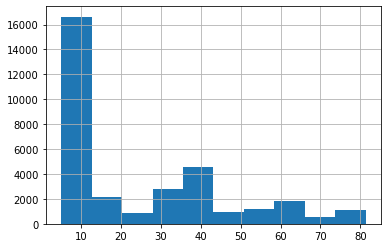

time: 508 ms


In [11]:
pd.Series(gb.predict(missing_age)).hist()

In [12]:
X_tr.shape

(751267, 26)

time: 1.56 ms


In [13]:
individual_df.loc[missing_age.index, 'age'] = gb.predict(missing_age).astype(int)
individual_df.loc[missing_age.index].head(1)

,serial,persons,strata,gq,urban,hhtype,nfams,pernum,famunit,famsize,...,mean_econ_stat_9,Name,SchoolLevel,Grant_Class,Ed_dist,Type,HotseatingIndicator,hotseating_session,phase,boardingschool
1161,160605000,8,2412,other group quarters,urban,group quarters,8 families,7,7,1 family member present,...,0.0063,ADMIRAL TAIT,Primary,P1,Harare,Government,1.0,Evening,2.0,Not Boarding School


time: 412 ms


In [14]:
individual_df.economic_status.astype(str).value_counts()

In School                                 4603312
Not working, inactive, not in universe    3655252
Agriculture Workers                       2407410
Service Workers                           2235255
Homemakers/Housework                      1323535
Office workers                             342493
Disabled and not working                   177445
Teachers                                   143152
Indusrtry Workers                          126592
In the army                                 43378
Name: economic_status, dtype: int64

time: 3.22 s


## Create `district_id`, `household_id` and `economic_activity_location_id`

In [15]:
relevant_cols = [
    'person_id', 'age', 'sex',
    'household_id', 'district_id',
    'economic_status', 'economic_activity_location_id',
    'school_id',
    'hotseating_session',
    'phase',
    'boardingschool'
    # 'household', 'district'
]

time: 427 µs


In [16]:
individual_df['Schoolnumber'].value_counts()

1219.0     6798
1274.0     4521
1037.0     4489
1208.0     4252
1182.0     4061
           ... 
1968.0        7
22009.0       7
3279.0        5
18611.0       4
17147.0       4
Name: Schoolnumber, Length: 9612, dtype: int64

time: 68.5 ms


In [17]:
old_new_districts = pd.read_csv(
    get_data_dir('raw', 'district_relation.csv'), index_col=0)
old_new_districts.index = old_new_districts['ADMIN_NAME'].str.lower()

time: 14.4 ms


In [18]:
individual_df['serial_expanded'] = individual_df['serial_cycle']

time: 287 ms


In [19]:
individual_df['new_district_id'].value_counts().head()

2     2442485
1      753227
7      524975
27     414437
55     379017
Name: new_district_id, dtype: int64

time: 105 ms


In [20]:
individual_df['household_id'] = individual_df['serial_expanded'].map(lambda x: f'h_{x}')
individual_df['new_district_id'] = individual_df['new_district_id'].map(lambda x: f'd_{x}')

time: 6.88 s


In [21]:
expanded_individual_df = individual_df.copy()
expanded_individual_df.head(1)

,serial,persons,strata,gq,urban,hhtype,nfams,pernum,famunit,famsize,...,SchoolLevel,Grant_Class,Ed_dist,Type,HotseatingIndicator,hotseating_session,phase,boardingschool,serial_expanded,household_id
0,155315000,4,2614,households,urban,married/cohab couple with children,1 family,3,1,4,...,Primary,P1,Harare,Government,1.0,Morning,5.0,Not Boarding School,15531500004,h_15531500004


time: 2.92 s


In [22]:
individual_df['hotseating_session'].value_counts()

0.0        3129600
Evening     804644
Morning     803641
Name: hotseating_session, dtype: int64

time: 36.6 ms


In [23]:
expanded_individual_df['school_goers'] = 1 * (expanded_individual_df['school_goers'] != 0)

time: 397 ms


In [24]:
(expanded_individual_df.groupby('serial_expanded')['sex'].count().mean(), 
expanded_individual_df.shape[0] / expanded_individual_df['serial_expanded'].nunique())

(4.073266636802549, 4.073266636802549)

time: 13.9 s


In [25]:
(expanded_individual_df['school_goers'] == 1).sum()

4737885

time: 31 ms


# Data consolidation

In [26]:
relevant_cols = [
    'person_id', 'age', 'sex',
    'household_id', 'district_id',
    'economic_status', 'economic_activity_location_id',
    # 'school_id_district', 
    'school_goers',
    'manufacturing_workers',
    'school_id',
    'hotseating_session', 
    'phase',
    'boardingschool'
    # 'mining_district_id'
    # 'household', 'district'
]

time: 413 µs


In [28]:
consolidated_df = expanded_individual_df.copy()

p = consolidated_df['economic_status']

consolidated_df.loc[p == 'Disabled and not working', 'economic_activity_location_id'] = consolidated_df.loc[p == 'Disabled and not working', 'household_id']
consolidated_df.loc[p != 'Disabled and not working', 'economic_activity_location_id'] = consolidated_df.loc[p != 'Disabled and not working', 'new_district_id']

try:
    consolidated_df.drop('person_id', axis=1, inplace=True)
except KeyError:
    pass

consolidated_df['person_id'] = consolidated_df.index
consolidated_df['age'] = consolidated_df['age'].astype(int)
consolidated_df['economic_status'] = consolidated_df['economic_status'].str.strip()

consolidated_df['school_id'] = consolidated_df['Schoolnumber'].fillna(-1).astype(int).map(lambda x: f's_{x}')  # if x != -1 else '')
consolidated_df['district_id'] = consolidated_df['new_district_id']

time: 33.7 s


In [29]:
consolidated_df[relevant_cols].to_pickle(
    get_data_dir('preprocessed', 'census', 'zimbabwe_expanded_census_consolidated_100pct.pickle'))

time: 33.4 s


In [39]:
consolidated_df[relevant_cols].head()

,person_id,age,sex,household_id,district_id,district_id,economic_status,economic_activity_location_id,school_goers,manufacturing_workers,school_id,hotseating_session,phase,boardingschool
0,0,4,male,h_15531500004,9022.0,d_2,Current Students,d_2,1,0.0,1001.0,Morning,5.0,Not Boarding School
1,1,6,female,h_15475300023,9022.0,d_2,Current Students,d_2,1,0.0,1001.0,Evening,4.0,Not Boarding School
2,2,5,male,h_15315800012,9022.0,d_2,Current Students,d_2,1,0.0,1001.0,Evening,5.0,Not Boarding School
3,3,6,male,h_14499300008,9021.0,d_2,Current Students,d_2,1,0.0,1001.0,Morning,4.0,Not Boarding School
4,4,6,male,h_14030400010,9021.0,d_2,Current Students,d_2,1,0.0,1001.0,Morning,4.0,Not Boarding School


time: 1.6 s


In [52]:
consolidated_df[relevant_cols][consolidated_df[relevant_cols]["phase"] == 1].head()

,person_id,age,sex,household_id,district_id,district_id,economic_status,economic_activity_location_id,school_goers,manufacturing_workers,school_id,hotseating_session,phase,boardingschool
11,11,12,male,h_13441800016,9021.0,d_2,Current Students,d_2,1,0.0,1001.0,Morning,1.0,Not Boarding School
14,14,12,female,h_15526500017,9022.0,d_2,Current Students,d_2,1,0.0,1001.0,Morning,1.0,Not Boarding School
20,20,12,female,h_15008500001,9021.0,d_2,Current Students,d_2,1,0.0,1001.0,Morning,1.0,Not Boarding School
21,21,13,male,h_13935000003,9021.0,d_2,Current Students,d_2,1,0.0,1001.0,Morning,1.0,Not Boarding School
32,32,14,male,h_13422100019,9021.0,d_2,Current Students,d_2,1,0.0,1001.0,Morning,1.0,Not Boarding School


time: 3.51 s


In [66]:
consolidated_df[consolidated_df['school_id'] != '']['school_id']

0           s_1001
1           s_1001
2           s_1001
3           s_1001
4           s_1001
            ...   
4737880    s_32211
4737881    s_32211
4737882    s_32211
4737883    s_32211
4737884    s_32211
Name: school_id, Length: 4737885, dtype: object

time: 3.19 s


In [68]:
consolidated_df.loc[consolidated_df['school_id'] != '', 'school_id'].unique()

array(['s_1001', 's_1002', 's_1003', ..., 's_22223', 's_22224', 's_32211'],
      dtype=object)

time: 1.34 s


In [33]:
consolidated_df[relevant_cols].head()

,person_id,age,sex,household_id,district_id,economic_status,economic_activity_location_id,school_goers,manufacturing_workers
0,0,19,female,h_67786,w_1,Service Workers,w_1,0,0.0
1,1,49,male,h_64925,w_1,Service Workers,w_1,0,0.0
2,2,26,female,h_3648785,w_1,Office workers,w_1,1,0.0
3,3,54,female,h_127965,w_1,Homemakers/Housework,w_1,0,0.0
4,4,65,female,h_103824,w_1,"Not working, inactive, not in universe",w_1,0,0.0


time: 790 ms


In [48]:
individual_df['mining_districts'].describe()

count    1.505782e+07
mean     2.136117e-01
std      4.098558e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+00
Name: mining_districts, dtype: float64

time: 650 ms


In [47]:
print(individual_df.columns[individual_df.columns.str.contains('manufacturing')])
print(individual_df.columns[individual_df.columns.str.contains('mining')])

Index(['manufacturing_workers'], dtype='object')
Index(['mining_workers', 'mining_districts'], dtype='object')
time: 1.55 ms


# Contingent on available data

In [19]:
# consolidated_df['serial_expanded'] = consolidated_df['serial'].map(lambda x: f'{x}_01')
# consolidated_df['household_id'] = consolidated_df['serial_expanded'].map(lambda x: f'h_{x}')
consolidated_df.loc[consolidated_df['mining_district_id'] != '', 'mining_district_id'] = consolidated_df.loc[consolidated_df['mining_district_id'] != '', 'mining_district_id'].map(lambda x: f'mining_{x}')
consolidated_df.loc[consolidated_df['school_id_district'] != '', 'school_id_district'] = consolidated_df.loc[consolidated_df['school_id_district'] != '', 'school_id_district'].map(lambda x: f'school_{x}')

time: 1.1 s


In [28]:
consolidated_df.head()

,serial,persons,district_id,new_district_id,age,sex,teachers,nfams,isco88a,famunit,...,dhs_ipumsi_zw,province_id_shpfile,province_name_shpfile,district_name_shpfile,serial_expanded,household_id,old_district_id,district_id,economic_activity_location_id,person_id
0,147171,8,21,1,34,female,0,1 family,niu (not in universe),1,...,bulawayo,1,Bulawayo,Bulawayo,147171,h_147171,w_21,w_1,w_1,0
1,21490,2,21,1,36,female,0,1 family,niu (not in universe),1,...,bulawayo,1,Bulawayo,Bulawayo,21490,h_21490,w_21,w_1,w_1,1
2,59596,3,21,1,25,female,0,1 family,"cashiers, tellers and related clerks",1,...,bulawayo,1,Bulawayo,Bulawayo,59596,h_59596,w_21,w_1,w_1,2
3,148162,8,21,1,33,male,0,1 family,"miners, shotfirers, stone cutters and carvers",1,...,bulawayo,1,Bulawayo,Bulawayo,148162,h_148162,w_21,w_1,w_1,3
4,149155,8,21,1,18,female,0,1 family,niu (not in universe),1,...,bulawayo,1,Bulawayo,Bulawayo,149155,h_149155,w_21,w_1,w_1,4


time: 21.7 ms


In [21]:
p = consolidated_df['economic_status']

consolidated_df.loc[p == 'Disabled and not working', 'economic_activity_location_id'] = consolidated_df.loc[p == 'Disabled and not working', 'household_id']
consolidated_df.loc[p != 'Disabled and not working', 'economic_activity_location_id'] = consolidated_df.loc[p != 'Disabled and not working', 'new_district_id']

time: 877 ms


In [22]:
try:
    consolidated_df.drop('person_id', axis=1, inplace=True)
except KeyError:
    pass

consolidated_df['person_id'] = consolidated_df.index
consolidated_df['age'] = consolidated_df['age'].astype(int)
consolidated_df['economic_status'] = consolidated_df['economic_status'].str.strip()
consolidated_df.rename(columns={'new_district_id': 'district_id'}, inplace=True)

time: 1.21 s


time: 870 µs


In [24]:
consolidated_df[relevant_cols][
    consolidated_df.serial_expanded.str.endswith('_01')
].to_pickle('../../data/zimbabwe_ipums_mining_manufacturing_school_new_dist_5pct.pickle')

time: 932 ms


In [25]:
consolidated_df[relevant_cols][
    consolidated_df.serial_expanded.str.endswith('_01') | consolidated_df.serial_expanded.str.endswith('_02')
].to_pickle('../../data/zimbabwe_ipums_mining_manufacturing_school_new_dist_10pct.pickle')

time: 1.73 s


In [26]:
consolidated_df.shape

(1309376, 69)

time: 2.32 ms


In [2]:
import pandas as pd

In [3]:
consolidated_df = pd.read_pickle('../../data/zimbabwe_ipums_mining_manufacturing_school_new_dist_10pct.pickle')

In [9]:
consolidated_df[consolidated_df['school_id_district'] != '']['person_id']

1              1
2              2
3              3
10            10
20            20
           ...  
654638    654638
654646    654646
654647    654647
654656    654656
654682    654682
Name: person_id, Length: 126990, dtype: int64

# Expand to 10%

In [23]:
mining_df

,serial,persons,hhwt,subsamp,strata,gq,urban,geolev1,Province,Province_str,...,manufacturing_workers,mining_workers,mining_districts,mining_district_id,serial_expanded,household_id,old_district_id,district_id,economic_activity_location_id,person_id
0,4908000,4,20,10th 1% subsample,12552,households,urban,716000,0,bulawayo,...,NaN,NaN,NaN,,4908000_01,h_4908000_01,w_21,w_1,w_1,0
1,944000,5,20,44th 1% subsample,893,households,urban,716000,0,bulawayo,...,NaN,NaN,NaN,,944000_01,h_944000_01,w_21,w_1,w_1,1
2,5669000,4,20,9th 1% subsample,6838,households,urban,716000,0,bulawayo,...,NaN,NaN,NaN,,5669000_01,h_5669000_01,w_21,w_1,w_1,2
3,3231000,8,20,37th 1% subsample,9404,households,urban,716000,0,bulawayo,...,NaN,NaN,NaN,,3231000_01,h_3231000_01,w_21,w_1,w_1,3
4,1544000,6,20,44th 1% subsample,3738,households,urban,716000,0,bulawayo,...,NaN,NaN,NaN,,1544000_01,h_1544000_01,w_21,w_1,w_1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
654683,107627000,8,20,4th 1% subsample,1741,households,rural,716007,7,midlands,...,NaN,NaN,NaN,,107627000_01,h_107627000_01,w_708,w_60,w_60,654683
654684,112072000,6,20,62nd 1% subsample,2077,households,urban,716007,7,midlands,...,NaN,NaN,NaN,,112072000_01,h_112072000_01,w_724,w_60,w_60,654684
654685,107362000,8,20,5th 1% subsample,13286,households,rural,716007,7,midlands,...,NaN,NaN,NaN,,107362000_01,h_107362000_01,w_708,w_60,w_60,654685
654686,107396000,8,20,79th 1% subsample,4246,households,rural,716007,7,midlands,...,NaN,NaN,NaN,,107396000_01,h_107396000_01,w_708,w_60,w_60,654686


time: 261 ms


# Scratch

In [32]:
mining_df[~mining_df['household_id'].str.startswith('h_')]['person_id'].values

array([   298,    315,    325, ..., 654637, 654654, 654659])

time: 143 ms


In [43]:
mining_df[mining_df.manufacturing_workers.notnull()].person_id

5              5
95            95
251          251
274          274
302          302
           ...  
654084    654084
654108    654108
654170    654170
654335    654335
654571    654571
Name: person_id, Length: 10471, dtype: int64

time: 16.8 ms


In [44]:
mining_df[mining_df['manufacturing_workers'].notnull()]['person_id'].values

array([     5,     95,    251, ..., 654170, 654335, 654571])

time: 16.3 ms


In [51]:
mining_df[mining_df['school_id_district'] != '']['person_id'].values

(63495,)

time: 46.2 ms


In [52]:
mining_df['school_id_district'].shape

(654688,)

time: 2.91 ms
